In [2]:
import random
import helper
import models
import numpy as np
import pandas as pd
import importlib as imp
from datetime import datetime
from matplotlib import pyplot as plt
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, utils

rs = 2018
random.seed(rs)
%matplotlib inline

## Get the tensor data

In [3]:
use_cuda = torch.cuda.is_available()
print('Using cuda: {}'.format(use_cuda))
torch.manual_seed(rs)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
batch_size = 1000
n_layers = 1

Using cuda: False


In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('data/', train=True, split='digits', download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('data/', train=False, split='digits', transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader_ordered = torch.utils.data.DataLoader(
    datasets.EMNIST('data/', train=False, split='digits', transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=len(test_loader.dataset), shuffle=False, **kwargs)

## Train and test a 1 layer model

**Note:** Netx represents an x layer network between 1 and 4 layers

In [5]:
model = models.get_model(n_layers, dropout_rate=0.2, n_filters=10, filter_size=5, fc_units=50)

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
start = datetime.now() 
for epoch in range(1):
    models.train(model, optimizer, train_loader, use_cuda, device, epoch, layers=1)
    print('Time elapsed {}'.format(datetime.now() - start))
    test_loss, correct = models.test(model, optimizer, test_loader, use_cuda, device, epoch, layers=n_layers)


Train Epoch: 0 [0/240000 (0%)]	Loss: 2.319825
Train Epoch: 0 [10000/240000 (4%)]	Loss: 2.286458
Train Epoch: 0 [20000/240000 (8%)]	Loss: 2.282016
Train Epoch: 0 [30000/240000 (12%)]	Loss: 2.266489
Train Epoch: 0 [40000/240000 (17%)]	Loss: 2.246410
Train Epoch: 0 [50000/240000 (21%)]	Loss: 2.223020
Train Epoch: 0 [60000/240000 (25%)]	Loss: 2.200586
Train Epoch: 0 [70000/240000 (29%)]	Loss: 2.200578
Train Epoch: 0 [80000/240000 (33%)]	Loss: 2.185060
Train Epoch: 0 [90000/240000 (38%)]	Loss: 2.166213
Train Epoch: 0 [100000/240000 (42%)]	Loss: 2.141095
Train Epoch: 0 [110000/240000 (46%)]	Loss: 2.119829
Train Epoch: 0 [120000/240000 (50%)]	Loss: 2.085577
Train Epoch: 0 [130000/240000 (54%)]	Loss: 2.073129
Train Epoch: 0 [140000/240000 (58%)]	Loss: 2.051764
Train Epoch: 0 [150000/240000 (62%)]	Loss: 2.012164
Train Epoch: 0 [160000/240000 (67%)]	Loss: 1.988908
Train Epoch: 0 [170000/240000 (71%)]	Loss: 1.980766
Train Epoch: 0 [180000/240000 (75%)]	Loss: 1.935532
Train Epoch: 0 [190000/240000

In [5]:
print('Test loss: {0:4.3f}'.format(test_loss))
print('Correct: {0:3.2f}%'.format(correct*100.))

Test loss: 1.732
Correct: 71.95%


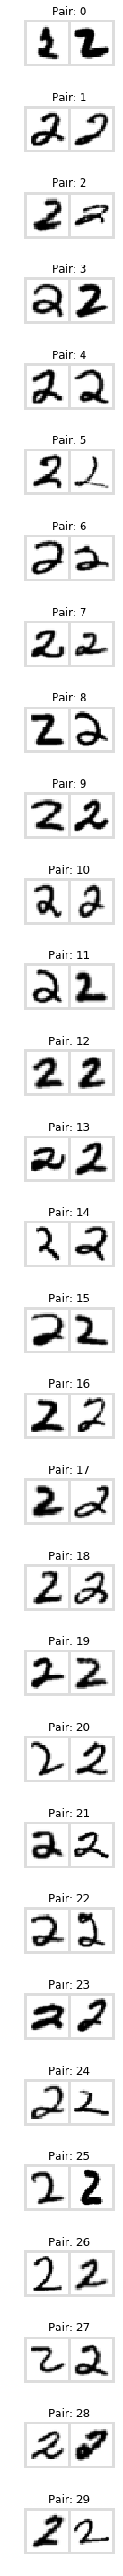

In [67]:
imp.reload(helper) # I don't really need to keep reloading this, but, meh, who cares
ix1, ix2, im1, im2 = helper.get_random_subset(test_loader_ordered, use_cuda, 2, npairs=30)

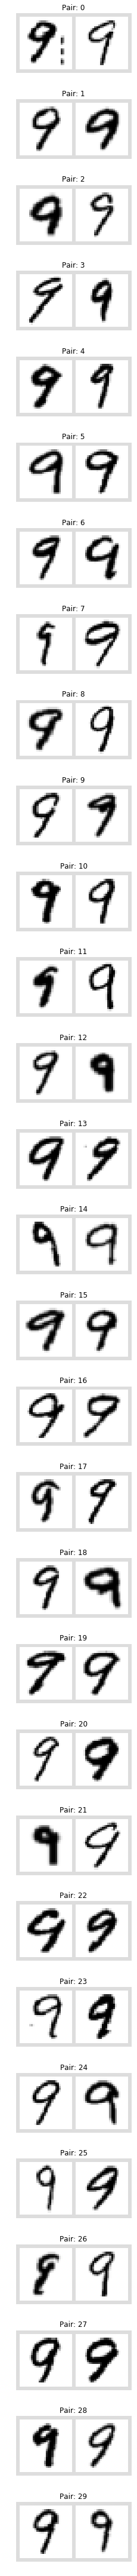

In [9]:
imp.reload(helper)
helper.plot_image_pairs(im1,im2)

In [75]:
imp.reload(helper)
helper.get_similarity_scores(im1,im2,model,layer='conv3')

array([0.84222769, 0.83816208, 0.63089437, 0.80822775, 0.89456464,
       0.78733896, 0.78754849, 0.8286247 , 0.83855366, 0.89084442,
       0.88446352, 0.90527192, 0.97509829, 0.77339581, 0.76692873,
       0.84585887, 0.91347908, 0.80680084, 0.7719109 , 0.90879825,
       0.78662365, 0.87631346, 0.91375729, 0.85130292, 0.82638126,
       0.85607229, 0.85152252, 0.8669329 , 0.88715906, 0.85617771])

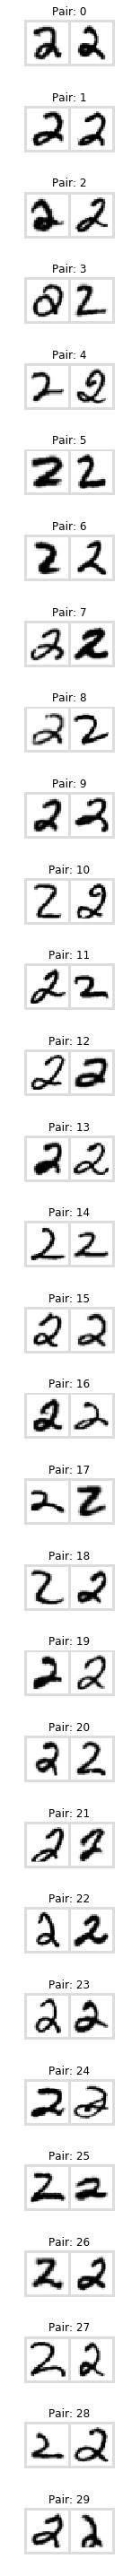

Correlation between net and human similarity ratings: r =
-0.278


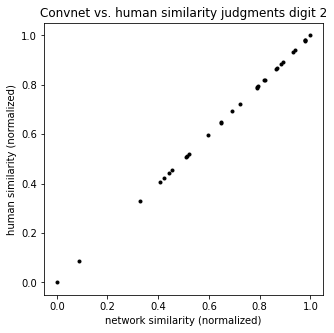

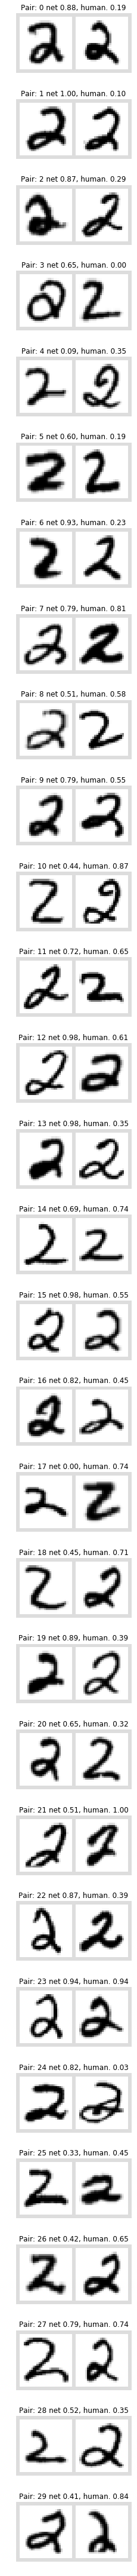

In [51]:
#Calculate Human Simlarity Scores
def normalize(v):
    # v : numpy vector
    v = v - v.min()
    v = v / v.max()
    return v


def simialairy_plots(human_score,model_scores):
    avg_human_score= np.mean(human_score, axis= 0)
    
    #Normalize Scores
    norm_human_score = normalize(avg_human_score)
    norm_model_score = normalize(model_scores)
    
    #Get Simalairity Judgements
    print("Correlation between net and human similarity ratings: r ="),
    print(round(np.corrcoef(norm_model_score,norm_human_score)[0][1],3))

    # Scatter plot
    plt.figure(1,figsize=(5,5))
    plt.plot(norm_model_score,norm_model_score,'k.')
    plt.xlabel('network similarity (normalized)')
    plt.ylabel('human similarity (normalized)')
    plt.title('Convnet vs. human similarity judgments '+ ('digit ' '%d') %(number)) 
    plt.show()

    #plot imagaes
    helper.plot_image_pairs(im1,im2,norm_model_score,norm_human_score)
    
    

number= 2 #number to sample
l= 'fc'

#Model Scores
ix1, ix2, im1, im2 = helper.get_random_subset(test_loader_ordered, use_cuda, number, npairs=30)
scores = helper.get_similarity_scores(im1,im2,model,layer=l)

#Human Scores
human_scores=np.random.randint(1,11, size=(8, 30)) #Each Row is set of human measurements
    
    
simialairy_plots(human_scores,scores)

    


### This might be useful?

In [ ]:
for name, param in model.named_parameters():
    print(name)
layers = [name.split('.')[0] for name, param in model.named_parameters() if all(x not in name for x in ('bias','fc2'))]
layers